In [1]:
%load_ext autoreload
%autoreload 2

from src.experiment import get_fallacy_df
from src.analysis import score_fallacy_identification, get_accuracies
from src.plot import plot_accuracies
from src.llms import LLM
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_theme()


# Fallacy Identification Analysis

## Dataset


In [2]:
df_fallacies_e1 = get_fallacy_df('data/fallacies_e1.csv')

df_fallacies_e1.head()

[2024-10-21 14:18:35] Loaded existing fallacy dataframe from data/fallacies_e1.csv.


,step,entity,fallacy,label,category,subcategory,gpt_4o_response,gpt_4_response,gpt_4o_mini_response,claude_3_5_sonnet_response,claude_3_opus_response,claude_3_haiku_response,gemini_1_5_pro_response,gemini_1_5_flash_response,gemini_1_5_flash_8b_response
0,Since John asked Maria if she used the last of...,tepas,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,No.,No.,No,No,No
1,Since Alice asked if Bob knew what an 'ossia' ...,ossia,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,No.,No.,No,No,No
2,Since Alice claims that the Hausdorff contents...,hausdorff contents,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,No.,No.,No,No,No
3,"Since Tom, a seasoned tugboater, said that ice...",tugboaters,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,No.,No.,Yes,No,No
4,Since John accuses Mary of being terrified of ...,beewolf,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,No.,No.,No,No,No


In [3]:
df_fallacies_count = df_fallacies_e1.groupby(['category', 'subcategory']).size().to_frame('count')
df_fallacies_count = df_fallacies_count.sort_values(by=['category', 'count'], ascending=[False, False]).reset_index()
df_fallacies_count

,category,subcategory,count
0,informal,irrelevance,1560
1,informal,insufficiency,1160
2,informal,inappropriate presumption,1080
3,informal,ambiguity,300
4,informal,inconsistency,60
5,formal,syllogistic,160
6,formal,propositional,120
7,formal,quantificational,120
8,formal,probabilistic,80


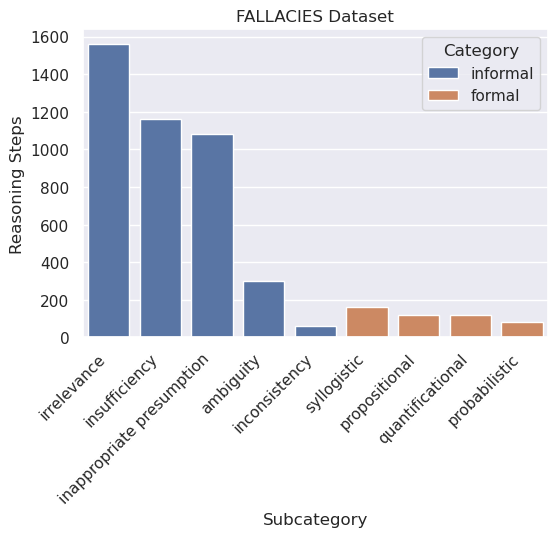

In [4]:
_, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x='subcategory', y='count', data=df_fallacies_count, hue='category', ax=ax)
plt.xticks(rotation=45, ha='right')
plt.title('FALLACIES Dataset')
plt.xlabel('Subcategory')
plt.ylabel('Reasoning Steps')
plt.legend(title='Category')

plt.show()

- The FALLACIES dataset contains 4640 reasoning steps, divided into 232 different fallacy types.
- For each fallacy type, there are 10 correct and 10 incorrect reasoning steps.
- The fallacy types are grouped into 4 formal and 5 informal subcategories.
- There are more informal than formal fallacy types.


## Experiment 1: Fallacy Identification with zero-shot Prompt

In [5]:
score_fallacy_identification(df_fallacies_e1)

df_fallacies_e1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   step                          4640 non-null   object
 1   entity                        4640 non-null   object
 2   fallacy                       4640 non-null   object
 3   label                         4640 non-null   int64 
 4   category                      4640 non-null   object
 5   subcategory                   4640 non-null   object
 6   gpt_4o_response               4640 non-null   object
 7   gpt_4_response                4640 non-null   object
 8   gpt_4o_mini_response          4640 non-null   object
 9   claude_3_5_sonnet_response    4640 non-null   object
 10  claude_3_opus_response        4640 non-null   object
 11  claude_3_haiku_response       4640 non-null   object
 12  gemini_1_5_pro_response       4640 non-null   object
 13  gemini_1_5_flash_r

### Global Scores

In [6]:
_, df_subcategory_accuracies_e1, df_category_accuracies_e1, df_global_accuracies_e1 = get_accuracies(df_fallacies_e1)

In [7]:
df_global_accuracies_e1 = df_global_accuracies_e1.sort_values('Accuracy', ascending=False)
df_global_accuracies_e1

,Accuracy
GPT-4,88.1
Gemini 1.5 Pro,87.1
GPT-4o,86.8
Claude 3 Opus,83.9
Claude 3.5 Sonnet,83.8
GPT-4o Mini,83.0
Gemini 1.5 Flash,82.2
Gemini 1.5 Flash 8B,81.3
Claude 3 Haiku,78.9


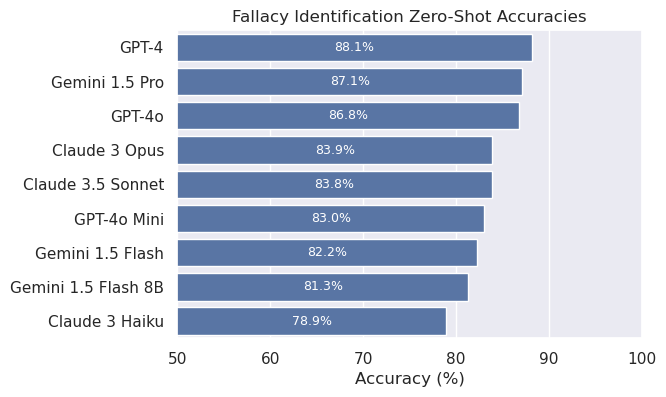

In [8]:
plot_accuracies(
    data=df_global_accuracies_e1.reset_index(), 
    figsize=(6, 4),
    title='Fallacy Identification Zero-Shot Accuracies',
    annotate=True,
)

### Scores by fallacy category

In [9]:
df_category_accuracies_e1

category,formal,informal
GPT-4,88.1,88.2
GPT-4o,85.4,88.1
GPT-4o Mini,79.0,87.1
Claude 3.5 Sonnet,85.0,82.5
Claude 3 Opus,84.8,83.1
Claude 3 Haiku,75.7,82.2
Gemini 1.5 Pro,87.6,86.7
Gemini 1.5 Flash,81.6,82.7
Gemini 1.5 Flash 8B,78.9,83.7


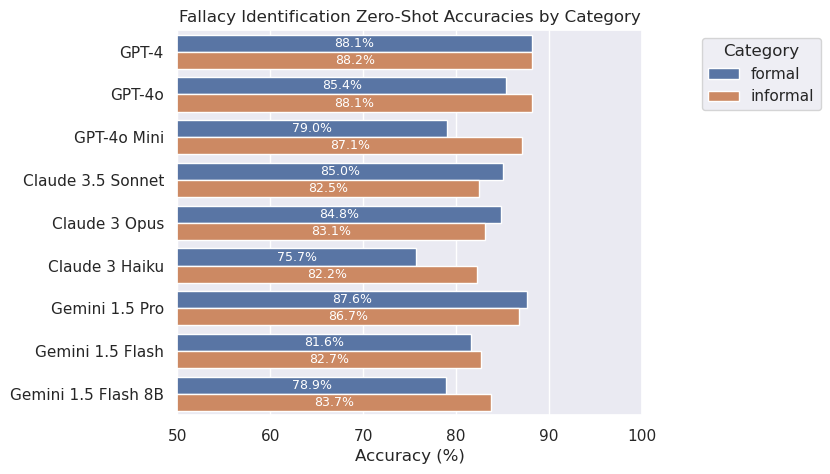

In [10]:
df_category_accuracies_long_e1 = pd.melt(df_category_accuracies_e1, var_name='Category', value_name='Accuracy', ignore_index=False)

plot_accuracies(
    data=df_category_accuracies_long_e1.reset_index(), 
    figsize=(6, 5),
    title='Fallacy Identification Zero-Shot Accuracies by Category',
    hue='Category',
    legend_title='Category',
    legend_anchor=(1.4, 1),
    annotate=True,
)

- Weaker models like GPT-4o Mini, Claude 3 Haiku, and Gemini 1.5 Flash 8B perform worse on formal compared to informal fallacy identification. This replicates the findings by Hong et al. (2024).

### Scores by fallacy subcategory

In [11]:
df_subcategory_accuracies_e1

category                   formal                                             \
subcategory         probabilistic propositional quantificational syllogistic   
GPT-4                        86.2          93.3             84.2        88.8   
GPT-4o                       87.5          83.3             80.8        90.0   
GPT-4o Mini                  77.5          80.0             74.2        84.4   
Claude 3.5 Sonnet            81.2          86.7             80.8        91.2   
Claude 3 Opus                83.7          85.0             86.7        83.8   
Claude 3 Haiku               78.8          69.2             74.2        80.6   
Gemini 1.5 Pro               88.8          85.0             85.8        90.6   
Gemini 1.5 Flash             76.2          81.7             81.7        86.9   
Gemini 1.5 Flash 8B          76.2          77.5             76.7        85.0   

category             informal                                          \
subcategory         ambiguity inappropriate presumption inconsistency   
GPT-4                    84.7                      86.9          85.0   
GPT-4o                   85.0                      87.0          88.3   
GPT-4o Mini              84.3                      87.0          86.7   
Claude 3.5 Sonnet        78.7                      84.3          81.7   
Claude 3 Opus            82.0                      84.0          83.3   
Claude 3 Haiku           81.0                      83.1          78.3   
Gemini 1.5 Pro           85.7                      88.1          80.0   
Gemini 1.5 Flash         80.0                      84.4          81.7   
Gemini 1.5 Flash 8B      81.7                      84.6          81.7   

category                                       
subcategory         insufficiency irrelevance  
GPT-4                        94.0        90.2  
GPT-4o                       92.4        87.9  
GPT-4o Mini                  91.1        86.3  
Claude 3.5 Sonnet            86.9        81.2  
Claude 3 Opus                86.6        79.6  
Claude 3 Haiku               85.9        82.7  
Gemini 1.5 Pro               92.1        87.8  
Gemini 1.5 Flash             86.6        80.7  
Gemini 1.5 Flash 8B          88.1        82.5

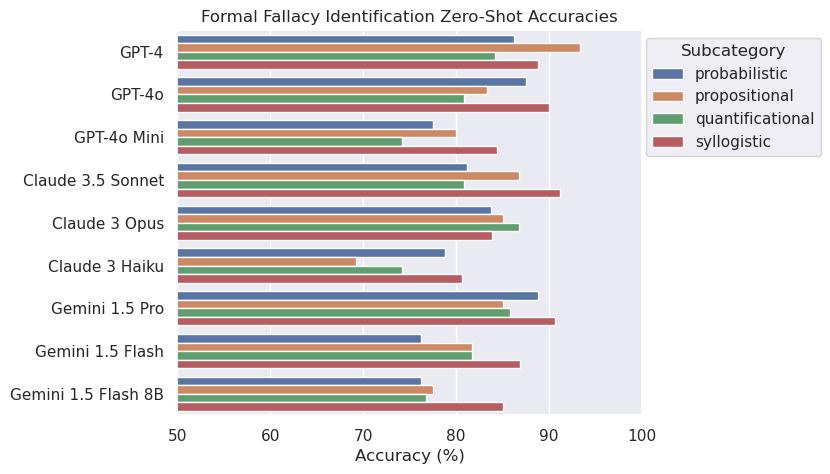

In [12]:
df_subcategory_accuracies_long_e1 = pd.melt(df_subcategory_accuracies_e1, value_name='Accuracy', ignore_index=False)
df_formal_accuracies_long_e1 = df_subcategory_accuracies_long_e1[df_subcategory_accuracies_long_e1['category'] == 'formal']

plot_accuracies(
    data=df_formal_accuracies_long_e1.reset_index(), 
    figsize=(6, 5),
    title='Formal Fallacy Identification Zero-Shot Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_anchor=(1.4, 1),
    annotate=False,
)

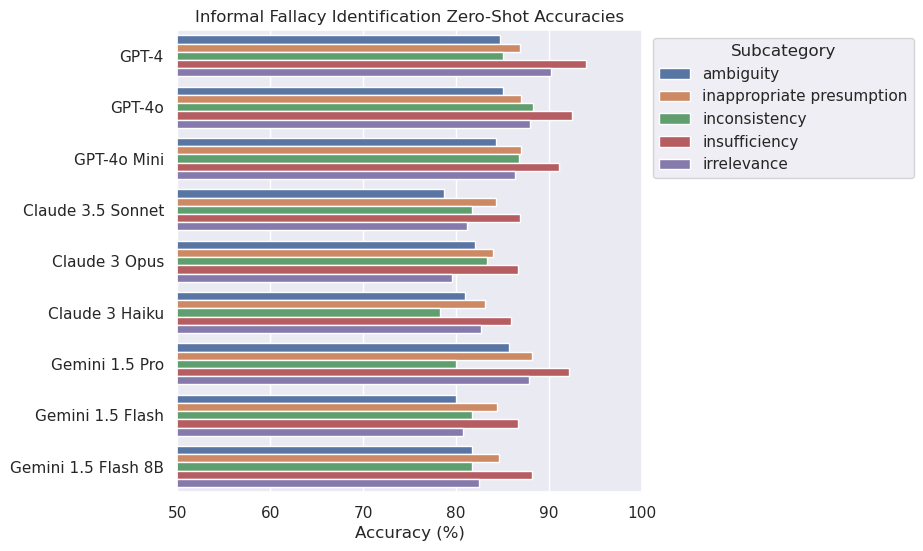

In [13]:
df_informal_accuracies_long_e1 = df_subcategory_accuracies_long_e1[df_subcategory_accuracies_long_e1['category'] == 'informal']

plot_accuracies(
    data=df_informal_accuracies_long_e1.reset_index(), 
    figsize=(6, 6),
    title='Informal Fallacy Identification Zero-Shot Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_anchor=(1.6, 1),
    annotate=False,
)

## Experiment 2: Fallacy Identification with few-shot Prompt

In [14]:
df_fallacies_e2 = get_fallacy_df('data/fallacies_e2.csv')

[2024-10-21 14:18:37] Loaded existing fallacy dataframe from data/fallacies_e2.csv.


In [15]:
score_fallacy_identification(df_fallacies_e2)

df_fallacies_e2.head()

,step,entity,fallacy,label,category,subcategory,gpt_4o_response,claude_3_5_sonnet_response,gemini_1_5_pro_response,gpt_4o_mini_response,claude_3_haiku_response,gemini_1_5_flash_response,gemini_1_5_flash_8b_response,gpt_4o_score,gpt_4o_mini_score,claude_3_5_sonnet_score,claude_3_haiku_score,gemini_1_5_pro_score,gemini_1_5_flash_score,gemini_1_5_flash_8b_score
0,Since John asked Maria if she used the last of...,tepas,Argument from Silence,1,informal,insufficiency,No.,No.,No.,No.,No.,No,No,1,1,1,1,1,1,1
1,Since Alice asked if Bob knew what an 'ossia' ...,ossia,Argument from Silence,1,informal,insufficiency,No.,No.,No.,No.,No.,No,No,1,1,1,1,1,1,1
2,Since Alice claims that the Hausdorff contents...,hausdorff contents,Argument from Silence,1,informal,insufficiency,No.,No.,No.,No.,No.,No,No,1,1,1,1,1,1,1
3,"Since Tom, a seasoned tugboater, said that ice...",tugboaters,Argument from Silence,1,informal,insufficiency,No.,No.,Yes.,No.,No.,No,No,1,1,1,1,0,1,1
4,Since John accuses Mary of being terrified of ...,beewolf,Argument from Silence,1,informal,insufficiency,No.,No.,No.,No.,No.,No,No,1,1,1,1,1,1,1


In [16]:
df_fallacies_e2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   step                          4640 non-null   object
 1   entity                        4640 non-null   object
 2   fallacy                       4640 non-null   object
 3   label                         4640 non-null   int64 
 4   category                      4640 non-null   object
 5   subcategory                   4640 non-null   object
 6   gpt_4o_response               4640 non-null   object
 7   claude_3_5_sonnet_response    4640 non-null   object
 8   gemini_1_5_pro_response       4640 non-null   object
 9   gpt_4o_mini_response          4640 non-null   object
 10  claude_3_haiku_response       4640 non-null   object
 11  gemini_1_5_flash_response     4640 non-null   object
 12  gemini_1_5_flash_8b_response  4640 non-null   object
 13  gpt_4o_score      

Very few responses contain invalid values. However, the prompts causing these invalid responses are of questionable quality or contain politically incorrect language. These responses are ignored when calculating the accuracies.

In [17]:
# Show invalid responses
df_fallacies_e2[df_fallacies_e2.isna().any(axis=1)]

,step,entity,fallacy,label,category,subcategory,gpt_4o_response,claude_3_5_sonnet_response,gemini_1_5_pro_response,gpt_4o_mini_response,claude_3_haiku_response,gemini_1_5_flash_response,gemini_1_5_flash_8b_response,gpt_4o_score,gpt_4o_mini_score,claude_3_5_sonnet_score,claude_3_haiku_score,gemini_1_5_pro_score,gemini_1_5_flash_score,gemini_1_5_flash_8b_score
37,Since I claim that benzopyran has magical prop...,benzopyran,Shifting of the Burden of Proof,0,informal,inappropriate presumption,Yes.,Yes.,Yes.,Yes.,Yes.,Yes No No Yes Yes,Yes,1,1,1,1,1,<NA>,1
57,Since seining is a traditional fishing method ...,seining,Political Correctness Fallacy,0,informal,irrelevance,Yes.,No.,Yes.,Yes.,No.,Yes No No Yes,No.,1,1,0,0,1,<NA>,0
69,Since I am either eating capulins or I am alle...,capulins,Affirming a Disjunct,1,formal,propositional,Yes.,Yes.,Yes.,No.,No.,Yes No No Yes Yes,Yes,0,1,0,1,0,<NA>,0
73,Since I need to buy either gold or hemalyke fo...,hemalyke,Affirming a Disjunct,0,formal,propositional,Yes.,Yes.,Yes.,Yes.,Yes.,Yes No No Yes Yes,Yes,1,1,1,1,1,<NA>,1
90,Since some ctenuchid moths are known to be act...,ctenuchid,gish gallop,0,informal,irrelevance,Yes.,Yes.,Yes. No. No. Yes. Yes. Yes. Yes.,Yes.,No.,Yes No No Yes,Yes.,1,1,1,0,<NA>,<NA>,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4530,Since most of the successful machinery we see ...,journal bearing,Survivorship Fallacy,0,informal,insufficiency,Yes.,Yes.,Yes.,Yes.,No.,Yes No No Yes,Yes,1,1,1,0,1,<NA>,1
4577,Since catching and selling cinclids is illegal...,cinclids,Appeal to the Law,0,informal,insufficiency,Yes.,Yes.,Yes.,Yes.,No.,Yes No No Yes Yes,Yes,1,1,1,0,1,<NA>,1
4591,Since I use a trundle wheel for measuring dist...,trundle wheel,Failure to Elucidate,0,informal,irrelevance,Yes.,Yes.,Yes.,Yes.,Yes.,Yes No No Yes Yes,Yes,1,1,1,1,1,<NA>,1
4593,Since I observed a changeable lizard in my gar...,changeable lizard,Failure to Elucidate,0,informal,irrelevance,No.,No.,No.,Yes.,No.,Yes No No Yes Yes,Yes,0,1,0,0,0,<NA>,1


### Global Scores

In [18]:
_, df_subcategory_accuracies_e2, df_category_accuracies_e2, df_global_accuracies_e2 = get_accuracies(df_fallacies_e2)

In [19]:
df_global_accuracies_e2 = df_global_accuracies_e2.sort_values('Accuracy', ascending=False)
df_global_accuracies_e2

,Accuracy
Gemini 1.5 Pro,85.7
GPT-4o,85.5
Claude 3.5 Sonnet,85.4
GPT-4o Mini,84.2
Gemini 1.5 Flash,78.8
Gemini 1.5 Flash 8B,77.6
Claude 3 Haiku,71.7


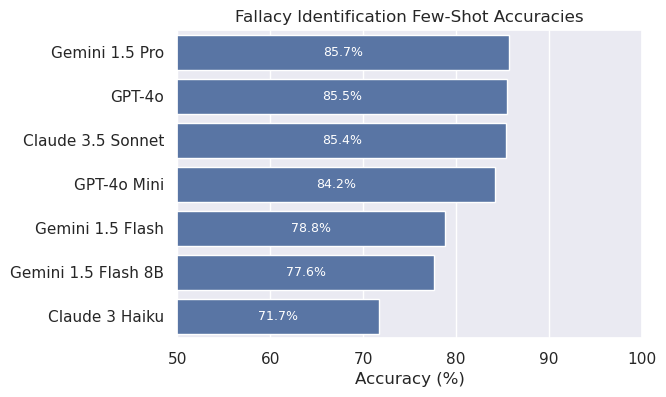

In [20]:
plot_accuracies(
    data=df_global_accuracies_e2.reset_index(), 
    figsize=(6, 4),
    title='Fallacy Identification Few-Shot Accuracies',
    annotate=True,
)

### Scores by fallacy category

In [21]:
df_category_accuracies_e2

category,formal,informal
GPT-4o,84.8,86.2
GPT-4o Mini,82.0,86.3
Claude 3.5 Sonnet,85.8,85.0
Claude 3 Haiku,69.8,73.6
Gemini 1.5 Pro,84.9,86.5
Gemini 1.5 Flash,78.2,79.4
Gemini 1.5 Flash 8B,76.3,78.8


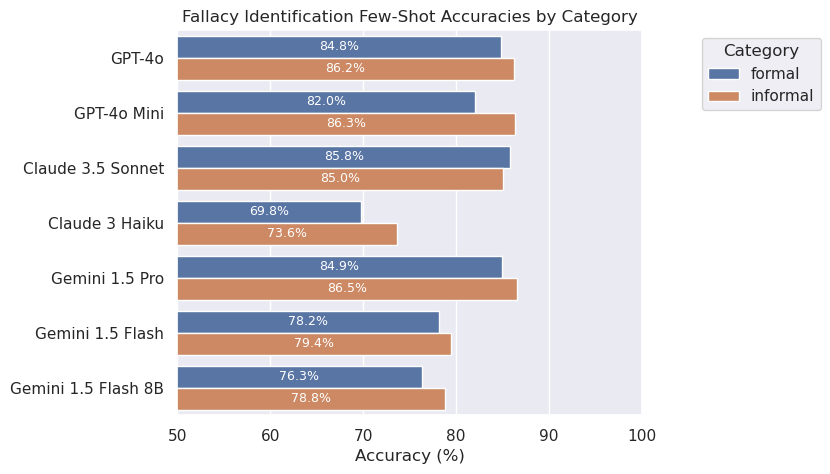

In [22]:
df_category_accuracies_long_e2 = pd.melt(df_category_accuracies_e2, var_name='Category', value_name='Accuracy', ignore_index=False)

plot_accuracies(
    data=df_category_accuracies_long_e2.reset_index(), 
    figsize=(6, 5),
    title='Fallacy Identification Few-Shot Accuracies by Category',
    hue='Category',
    legend_title='Category',
    legend_anchor=(1.4, 1),
    annotate=True,
)

### Scores by fallacy subcategory

In [23]:
df_subcategory_accuracies_e2

category                   formal                                             \
subcategory         probabilistic propositional quantificational syllogistic   
GPT-4o                       87.5          85.0             76.7        90.0   
GPT-4o Mini                  76.2          88.3             75.8        87.5   
Claude 3.5 Sonnet            85.0          82.5             85.0        90.6   
Claude 3 Haiku               70.0          61.3             70.0        77.9   
Gemini 1.5 Pro               86.2          83.3             83.3        86.9   
Gemini 1.5 Flash             73.9          70.4             80.8        87.8   
Gemini 1.5 Flash 8B          75.0          72.5             73.3        84.4   

category             informal                                          \
subcategory         ambiguity inappropriate presumption inconsistency   
GPT-4o                   84.7                      86.9          83.3   
GPT-4o Mini              84.3                      87.3          81.7   
Claude 3.5 Sonnet        83.0                      84.3          88.3   
Claude 3 Haiku           73.8                      75.3          71.7   
Gemini 1.5 Pro           85.0                      85.5          83.3   
Gemini 1.5 Flash         79.3                      76.5          87.7   
Gemini 1.5 Flash 8B      80.0                      78.1          78.3   

category                                       
subcategory         insufficiency irrelevance  
GPT-4o                       90.3        85.6  
GPT-4o Mini                  90.6        87.8  
Claude 3.5 Sonnet            87.0        82.5  
Claude 3 Haiku               75.1        72.4  
Gemini 1.5 Pro               90.0        88.5  
Gemini 1.5 Flash             75.9        77.5  
Gemini 1.5 Flash 8B          80.8        76.9

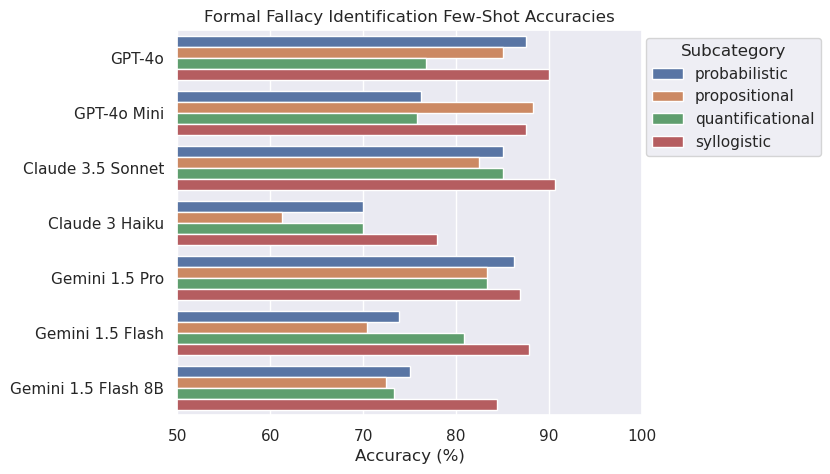

In [24]:
df_subcategory_accuracies_long_e2 = pd.melt(df_subcategory_accuracies_e2, value_name='Accuracy', ignore_index=False)
df_formal_accuracies_long_e2 = df_subcategory_accuracies_long_e2[df_subcategory_accuracies_long_e2['category'] == 'formal']

plot_accuracies(
    data=df_formal_accuracies_long_e2.reset_index(), 
    figsize=(6, 5),
    title='Formal Fallacy Identification Few-Shot Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_anchor=(1.4, 1),
    annotate=False,
)

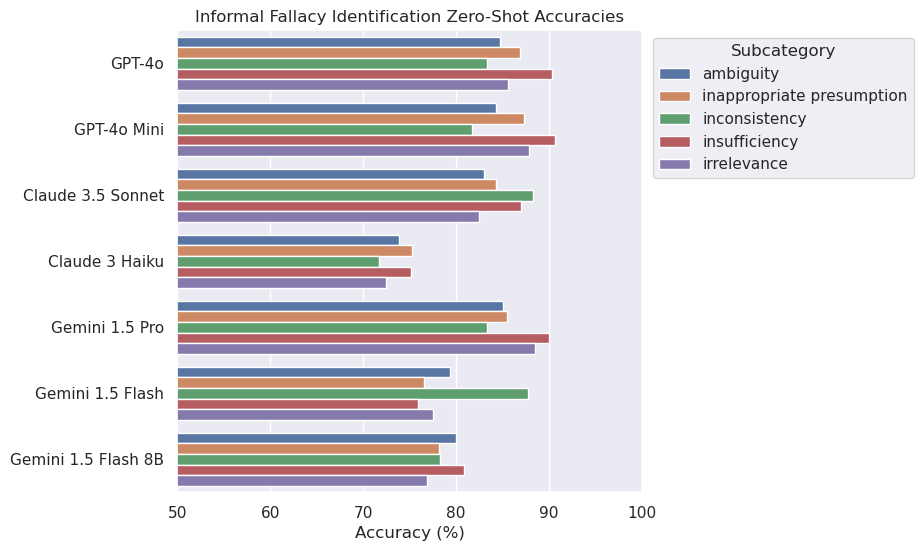

In [25]:
df_informal_accuracies_long_e2 = df_subcategory_accuracies_long_e2[
    df_subcategory_accuracies_long_e2['category'] == 'informal']

plot_accuracies(
    data=df_informal_accuracies_long_e2.reset_index(),
    figsize=(6, 6),
    title='Informal Fallacy Identification Zero-Shot Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_anchor=(1.6, 1),
    annotate=False,
)

## Experiment 3: Fallacy Identification with chain-of-thought Prompt

In [26]:
df_fallacies_e3 = get_fallacy_df('data/fallacies_e3.csv')

[2024-10-21 14:18:38] Loaded existing fallacy dataframe from data/fallacies_e3.csv.


In [27]:
score_fallacy_identification(df_fallacies_e3)

df_fallacies_e3.head()

,step,entity,fallacy,label,category,subcategory,gpt_4o_response,claude_3_5_sonnet_response,gemini_1_5_pro_response,gpt_4o_mini_response,claude_3_haiku_response,gemini_1_5_flash_response,gemini_1_5_flash_8b_response,gpt_4o_score,gpt_4o_mini_score,claude_3_5_sonnet_score,claude_3_haiku_score,gemini_1_5_pro_score,gemini_1_5_flash_score,gemini_1_5_flash_8b_score
0,Since John asked Maria if she used the last of...,tepas,Argument from Silence,1,informal,insufficiency,No. The reasoning step is not necessarily corr...,Let's think through this step-by-step: 1. Joh...,No. Silence is not necessarily an admission o...,No.,Let's analyze this step-by-step: 1. John aske...,No. Silence doesn't necessarily mean guilt or...,No. Silence doesn't necessarily mean agreemen...,1,1,1,1,1,1,1
1,Since Alice asked if Bob knew what an 'ossia' ...,ossia,Argument from Silence,1,informal,insufficiency,No. The reasoning step is not correct. Bob's s...,Let's think through this step by step: 1. Ali...,No. Silence could indicate a lack of knowledg...,No.,Let's analyze this step-by-step: 1. Alice ask...,No. Silence doesn't imply knowledge. Bob's s...,No. Silence does not equate to knowledge. Bo...,1,1,1,1,1,1,1
2,Since Alice claims that the Hausdorff contents...,hausdorff contents,Argument from Silence,1,informal,insufficiency,No. The reasoning step is not correct. The con...,Let's think through this step-by-step: 1. Ali...,No. Bob's silence doesn't confirm Alice's cla...,No.,Let's analyze this step-by-step: 1. Alice cla...,No. Bob's silence doesn't provide evidence su...,"No. Alice's claim, even if true, and Bob's si...",1,1,1,1,1,1,1
3,"Since Tom, a seasoned tugboater, said that ice...",tugboaters,Argument from Silence,1,informal,insufficiency,No. The reasoning step is not necessarily corr...,Let's think through this step-by-step: 1. The...,"No. While Tom's experience is valuable, the a...",No.,"Let's analyze this step-by-step: 1. Tom, a se...",No. The reasoning commits an appeal to author...,No. Just because one person says something an...,1,1,1,1,1,1,1
4,Since John accuses Mary of being terrified of ...,beewolf,Argument from Silence,1,informal,insufficiency,No. The reasoning step is not correct. The fac...,Let's think through this step-by-step: 1. Joh...,No. Silence does not imply guilt or fear. Ma...,No.,Let's analyze this step-by-step: 1. John accu...,No. Silence does not equal guilt or fear. Ma...,No. Silence in the face of an accusation does...,1,1,1,1,1,1,1


In [28]:
df_fallacies_e3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   step                          4640 non-null   object
 1   entity                        4640 non-null   object
 2   fallacy                       4640 non-null   object
 3   label                         4640 non-null   int64 
 4   category                      4640 non-null   object
 5   subcategory                   4640 non-null   object
 6   gpt_4o_response               4640 non-null   object
 7   claude_3_5_sonnet_response    4640 non-null   object
 8   gemini_1_5_pro_response       4640 non-null   object
 9   gpt_4o_mini_response          4640 non-null   object
 10  claude_3_haiku_response       4640 non-null   object
 11  gemini_1_5_flash_response     4640 non-null   object
 12  gemini_1_5_flash_8b_response  4640 non-null   object
 13  gpt_4o_score      

Very few responses contain invalid values. However, the prompts causing these invalid responses are of questionable quality or contain politically incorrect language. These responses are ignored when calculating the accuracies.

In [29]:
# Show invalid responses
df_fallacies_e3_invalid = df_fallacies_e3[df_fallacies_e3.isna().any(axis=1)]
df_fallacies_e3_invalid.head()

,step,entity,fallacy,label,category,subcategory,gpt_4o_response,claude_3_5_sonnet_response,gemini_1_5_pro_response,gpt_4o_mini_response,claude_3_haiku_response,gemini_1_5_flash_response,gemini_1_5_flash_8b_response,gpt_4o_score,gpt_4o_mini_score,claude_3_5_sonnet_score,claude_3_haiku_score,gemini_1_5_pro_score,gemini_1_5_flash_score,gemini_1_5_flash_8b_score
15,Since Tim asked John if he had seen his boonk ...,boonk,Argument from Silence,0,informal,insufficiency,Yes. The reasoning is correct. John's silence ...,Let's think through this step-by-step: 1. Tim...,Yes. Silence doesn't confirm or deny anything...,No.,Let's think through this step-by-step: 1. Tim...,Yes. Silence doesn't confirm or deny anything.,Yes. Silence doesn't indicate knowledge or la...,1,0,1,1,1,1,<NA>
16,Since Samantha claims that wheelbirds exist in...,wheelbirds,Argument from Silence,0,informal,insufficiency,Yes. The reasoning is correct. Samantha's clai...,Let's think through this step by step: 1. Sam...,"Yes. Samantha's claim without evidence, coupl...",Yes.,Let's analyze this step-by-step: 1. Samantha ...,Yes,Yes.,1,1,<NA>,1,1,1,1
60,Since I will visit Cornwallis now or I will st...,cornwallis,Affirming a Disjunct,1,formal,propositional,"Yes, the reasoning step is correct. The statem...",Let's break this down step by step: 1. We sta...,"Let C represent ""I will visit Cornwallis now"" ...",Yes.,Let's analyze this step-by-step: 1. The premi...,Yes. This is a correct application of disjunc...,Yes. The statement establishes a mutually exc...,<NA>,0,0,0,1,0,0
111,Since all bitrades are mathematical objects an...,bitrades,Fallacy of the Undistributed Middle,0,formal,syllogistic,Yes. The reasoning step is correct. The statem...,Let's think through this step-by-step: 1. We ...,Yes. The reasoning is that if two sets are bo...,Yes.,Let's analyze this step-by-step: 1. Premise: ...,Yes. This is a correct application of a simpl...,Yes,1,1,<NA>,1,1,1,1
174,Since I used to think lucules were a myth and ...,lucule,Statement of Conversion,0,informal,irrelevance,Yes. The reasoning step is correct. If you ini...,Let's break this down step by step: 1. The pr...,No. Absence of evidence is not evidence of ab...,No.,Let's analyze the reasoning step-by-step: 1. ...,No. The reasoning is flawed because the absen...,No. While the lack of scientific evidence sup...,<NA>,0,0,<NA>,0,0,0


### Global Scores

In [30]:
_, df_subcategory_accuracies_e3, df_category_accuracies_e3, df_global_accuracies_e3 = get_accuracies(df_fallacies_e3)

In [31]:
df_global_accuracies_e3 = df_global_accuracies_e3.sort_values('Accuracy', ascending=False)
df_global_accuracies_e3

,Accuracy
GPT-4o,88.0
Gemini 1.5 Pro,84.6
Claude 3.5 Sonnet,83.8
Claude 3 Haiku,83.1
GPT-4o Mini,81.6
Gemini 1.5 Flash,80.0
Gemini 1.5 Flash 8B,77.6


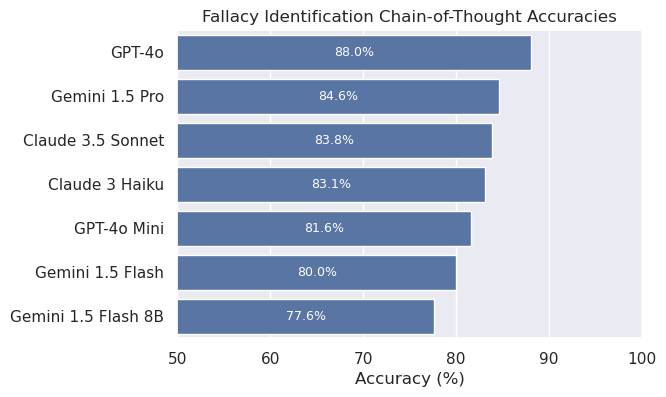

In [32]:
plot_accuracies(
    data=df_global_accuracies_e3.reset_index(), 
    figsize=(6, 4),
    title='Fallacy Identification Chain-of-Thought Accuracies',
    annotate=True,
)

### Scores by fallacy category

In [33]:
df_category_accuracies_e3

category,formal,informal
GPT-4o,86.3,89.8
GPT-4o Mini,76.2,86.9
Claude 3.5 Sonnet,87.3,80.2
Claude 3 Haiku,79.1,87.1
Gemini 1.5 Pro,84.8,84.5
Gemini 1.5 Flash,80.6,79.5
Gemini 1.5 Flash 8B,75.1,80.1


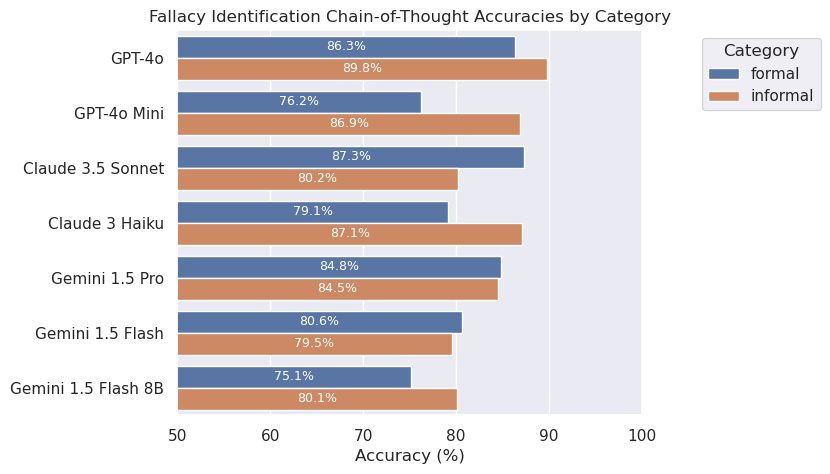

In [34]:
df_category_accuracies_long_e3 = pd.melt(df_category_accuracies_e3, var_name='Category', value_name='Accuracy', ignore_index=False)

plot_accuracies(
    data=df_category_accuracies_long_e3.reset_index(), 
    figsize=(6, 5),
    title='Fallacy Identification Chain-of-Thought Accuracies by Category',
    hue='Category',
    legend_title='Category',
    legend_anchor=(1.4, 1),
    annotate=True,
)

### Scores by fallacy subcategory

In [35]:
df_subcategory_accuracies_e3

category                   formal                                             \
subcategory         probabilistic propositional quantificational syllogistic   
GPT-4o                       87.2          83.3             83.6        91.0   
GPT-4o Mini                  77.5          74.2             72.5        80.5   
Claude 3.5 Sonnet            84.7          90.6             86.8        87.3   
Claude 3 Haiku               77.5          74.7             76.5        87.5   
Gemini 1.5 Pro               82.1          89.0             79.9        88.1   
Gemini 1.5 Flash             77.5          81.7             77.5        85.9   
Gemini 1.5 Flash 8B          76.2          70.8             73.8        79.7   

category             informal                                          \
subcategory         ambiguity inappropriate presumption inconsistency   
GPT-4o                   86.9                      88.7          91.7   
GPT-4o Mini              83.7                      88.0          86.7   
Claude 3.5 Sonnet        74.0                      83.2          80.2   
Claude 3 Haiku           84.7                      88.1          88.2   
Gemini 1.5 Pro           82.2                      86.2          79.6   
Gemini 1.5 Flash         80.0                      79.7          81.7   
Gemini 1.5 Flash 8B      77.9                      79.1          83.3   

category                                       
subcategory         insufficiency irrelevance  
GPT-4o                       92.5        89.1  
GPT-4o Mini                  90.7        85.7  
Claude 3.5 Sonnet            84.6        78.7  
Claude 3 Haiku               88.5        85.9  
Gemini 1.5 Pro               88.4        86.1  
Gemini 1.5 Flash             80.1        75.8  
Gemini 1.5 Flash 8B          82.5        77.6

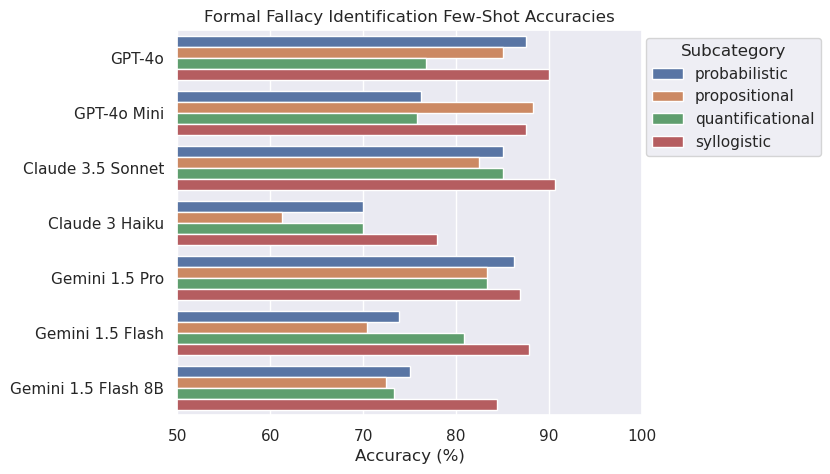

In [36]:
df_subcategory_accuracies_long_e3 = pd.melt(df_subcategory_accuracies_e3, value_name='Accuracy', ignore_index=False)
df_formal_accuracies_long_e3 = df_subcategory_accuracies_long_e2[df_subcategory_accuracies_long_e3['category'] == 'formal']

plot_accuracies(
    data=df_formal_accuracies_long_e3.reset_index(), 
    figsize=(6, 5),
    title='Formal Fallacy Identification Few-Shot Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_anchor=(1.4, 1),
    annotate=False,
)

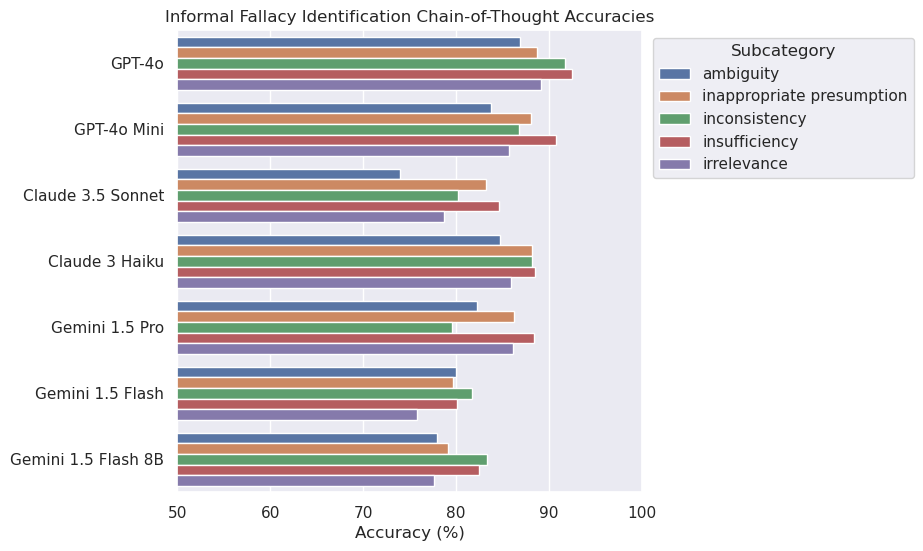

In [37]:
df_informal_accuracies_long_e3 = df_subcategory_accuracies_long_e3[
    df_subcategory_accuracies_long_e3['category'] == 'informal']

plot_accuracies(
    data=df_informal_accuracies_long_e3.reset_index(), 
    figsize=(6, 6),
    title='Informal Fallacy Identification Chain-of-Thought Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_anchor=(1.6, 1),
    annotate=False,
)

## Prompt Method Comparison

In [40]:
df_global_accuracies_e1['Method'] = 'zero-shot'
df_global_accuracies_e2['Method'] = 'few-shot'
df_global_accuracies_e3['Method'] = 'chain-of-thought'
df_accuracies_methods = pd.concat([df_global_accuracies_e1, df_global_accuracies_e2, df_global_accuracies_e3])
df_accuracies_methods = df_accuracies_methods.loc[
    [LLM.GPT_4O.label, LLM.GEMINI_1_5_PRO.label, LLM.CLAUDE_3_5_SONNET.label, 
     LLM.GPT_4O_MINI.label, LLM.GEMINI_1_5_FLASH.label, LLM.CLAUDE_3_HAIKU.label]
]

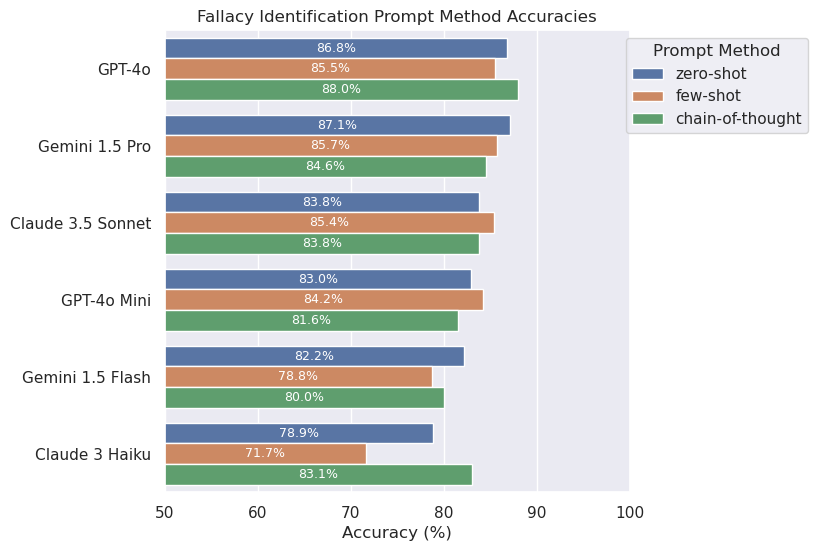

In [42]:
plot_accuracies(
    data=df_accuracies_methods.reset_index(), 
    figsize=(6, 6),
    title='Fallacy Identification Prompt Method Accuracies',
    hue='Method',
    legend_title='Prompt Method',
    legend_anchor=(1.4, 1),
    annotate=True,
)